In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [2]:
!tar -xvf 'drive/MyDrive/Harvard/BMI707/Data/OCT2017.tar.gz' -C './'

Streaming output truncated to the last 5000 lines.
./OCT2017/train/CNV/CNV-5674369-84.jpeg
./OCT2017/train/CNV/CNV-6666538-574.jpeg
./OCT2017/train/CNV/CNV-1188386-603.jpeg
./OCT2017/train/CNV/CNV-1781140-74.jpeg
./OCT2017/train/CNV/CNV-7315522-30.jpeg
./OCT2017/train/CNV/CNV-8082730-14.jpeg
./OCT2017/train/CNV/CNV-1781140-180.jpeg
./OCT2017/train/CNV/CNV-7907754-413.jpeg
./OCT2017/train/CNV/CNV-137351-113.jpeg
./OCT2017/train/CNV/CNV-4244160-134.jpeg
./OCT2017/train/CNV/CNV-9642260-283.jpeg
./OCT2017/train/CNV/CNV-732516-169.jpeg
./OCT2017/train/CNV/CNV-2192440-174.jpeg
./OCT2017/train/CNV/CNV-9206459-7.jpeg
./OCT2017/train/CNV/CNV-9598696-112.jpeg
./OCT2017/train/CNV/CNV-1651625-37.jpeg
./OCT2017/train/CNV/CNV-172472-51.jpeg
./OCT2017/train/CNV/CNV-1894770-40.jpeg
./OCT2017/train/CNV/CNV-4612183-53.jpeg
./OCT2017/train/CNV/CNV-9642260-241.jpeg
./OCT2017/train/CNV/CNV-8184974-60.jpeg
./OCT2017/train/CNV/CNV-2158821-4.jpeg
./OCT2017/train/CNV/CNV-9997680-79.jpeg
./OCT2017/train/CNV/CNV

In [92]:
training_size = 4000
num_class = 4

imageSize=224
train_dir = "./OCT2017/train/"
test_dir =  "./OCT2017/test/"

from tqdm import tqdm
import os
import cv2
import numpy as np
import skimage

def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                label = 4
            for image_filename in tqdm(os.listdir(folder + folderName)[:training_size // num_class]):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

X_train, y_train = get_data(train_dir)
X_test, y_test= get_data(test_dir)

100%|██████████| 250/250 [00:06<00:00, 35.84it/s]


In [93]:
unique, counts = np.unique(y_train, return_counts=True)

print(X_train.shape)
print(X_test.shape)

for label, count in zip(unique, counts):
  print("The number of {} samples: {}".format(label, count))

(4000, 224, 224, 3)
(1000, 224, 224, 3)
The number of 0 samples: 1000
The number of 1 samples: 1000
The number of 2 samples: 1000
The number of 3 samples: 1000


In [94]:
from transformers import AutoImageProcessor, ViTModel
import torch
import torch.utils.data as Data
from tqdm import tqdm
import copy

In [119]:
class Vision_Transformer(torch.nn.Module):
    def __init__(self, link="google/vit-base-patch16-224-in21k", device='cpu', freeze_embedding=True):
        super(Vision_Transformer, self).__init__()
        self.image_processor = AutoImageProcessor.from_pretrained(link, do_rescale=False)
        self.embedding = ViTModel.from_pretrained(link)
        self.embedding_dim = self.embedding.config.hidden_size

        self.classifier = torch.nn.Sequential(
          torch.nn.Linear(self.embedding_dim, 256),
          torch.nn.ReLU(),
          torch.nn.Dropout(0.25),
          torch.nn.Linear(256, 128),
          torch.nn.ReLU(),
          torch.nn.Dropout(0.25),
          torch.nn.Linear(128, 4),
          torch.nn.Softmax(dim=-1)
        )

        if freeze_embedding:
            for para in self.embedding.parameters():
                para.requires_grad = False
        else:
            for para in self.embedding.parameters():
                para.requires_grad = True

        self.to(device)

    def forward(self, x, output_attention=False):
        inputs = self.image_processor(x, return_tensors='pt')
        encoded_input = {key: value.to(next(self.parameters()).device) for key, value in inputs.items()}

        model_output = self.embedding(**encoded_input, output_attentions=output_attention)

        embeddings = model_output.last_hidden_state[:, 0, :]
        logits = self.classifier(embeddings)

        if output_attention:
          return logits, model_output.attentions
        else:
          return logits

In [145]:
class DLClassifier():
    def __init__(self, model, lr, minibatch, epoch, verbose=True, cuda=False):
        self.model = model
        self.best_model = None
        self.loss = None
        self.val_loss = None
        self.epoch = epoch
        self.lr = lr
        self.minibatch = minibatch
        self.optimizer = None
        self.scheduler = None
        self.criterion = None
        self.verbose = verbose
        self.cuda = cuda

    def fit(self, x_train, y_train, x_test, y_test, save_best=True):
        torch_dataset = Data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
        loader = Data.DataLoader(
            dataset=torch_dataset,
            batch_size=self.minibatch,
            shuffle=True,
            drop_last=False
        )

        if self.cuda and torch.cuda.is_available():
            self.model = self.model.cuda()
            self.criterion = torch.nn.CrossEntropyLoss().cuda()
        else:
            self.model = self.model.cpu()
            self.criterion = torch.nn.CrossEntropyLoss()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=20,
                                                               verbose=False, threshold=0.0001, threshold_mode='rel',
                                                               cooldown=0, min_lr=1e-05, eps=1e-08)

        loss_list = []
        valid_loss_list = []

        train_acc_list = []
        test_acc_list = []

        min_loss_val = 1e10

        for epoch in range(self.epoch):
            self.model.train()
            epoch_loss = 0
            loss_ = 0
            train_preds_correct = []
            for idx, (x, target) in enumerate(tqdm(loader), 0):
                if self.cuda and torch.cuda.is_available():
                    x = x.cuda()
                    target = target.cuda()
                else:
                    x = x.cpu()
                    target = target.cpu()
                predict = self.model(x)
                correct_train = int(torch.sum(torch.argmax(predict, dim=1) == target))
                train_preds_correct.append(correct_train)
                #            losses.append(loss)
                self.optimizer.zero_grad()
                loss = self.criterion(predict, target.long())

                loss.backward()
                self.optimizer.step()
                #self.scheduler.step(loss)
                epoch_loss += loss.item()
                loss_ = epoch_loss / (idx + 1)
                del x, target, predict
                if self.cuda and torch.cuda.is_available():
                    torch.cuda.empty_cache()
            train_acc = sum(train_preds_correct)/x_train.shape[0]
            train_acc_list.append(train_acc)
            loss_list.append(loss_)
            with torch.no_grad():
                if self.cuda and torch.cuda.is_available():
                    pred = self.model(torch.tensor(x_test).cuda())
                    y = torch.tensor(y_test).cuda()
                else:
                    pred = self.model(torch.tensor(x_test))
                    y = torch.tensor(y_test)
                valid_loss = self.criterion(pred, y.long())
                valid_loss_list.append(valid_loss.item())
                if self.verbose:
                    correct = int(torch.sum(torch.argmax(pred, dim=1) == y))
                    total = len(y)
                    print("Epoch={}/{}, train_loss={}, valid_loss={}, valid_acc={:.3f}, lr={}".format(
                        epoch + 1, self.epoch, loss_, valid_loss, correct / total,
                        self.optimizer.state_dict()['param_groups'][0]['lr']))
                test_acc_list.append(correct / total)
                if save_best:
                  if valid_loss <= min_loss_val and epoch > 5:
                      min_loss_val = valid_loss
                      self.best_model = copy.deepcopy(self.model)
        self.loss = loss_list
        self.val_loss = valid_loss_list

        self.accuracy = train_acc_list
        self.val_accuracy = test_acc_list

        print('Training finished.')

    def predict(self, X):
        self.model.eval()

        torch_dataset = Data.TensorDataset(torch.from_numpy(X), torch.zeros(X.shape[0]))
        loader = Data.DataLoader(
            dataset=torch_dataset,
            batch_size=self.minibatch,
            shuffle=False,
            drop_last=False
        )

        preds = []

        for idx, batch in enumerate(tqdm(loader)):
            if self.cuda and torch.cuda.is_available():
                x = batch[0].cuda()
            else:
                x = batch[0].cpu()
            outputs = self.best_model(x)
            preds.append(outputs)
        preds = torch.concatenate(preds, dim=0)
        preds = torch.argmax(preds, dim=1).cpu().numpy().astype('int64')
        return preds

    def predict_prob(self, X):
        self.model.eval()

        torch_dataset = Data.TensorDataset(torch.from_numpy(X), torch.zeros(X.shape[0]))
        loader = Data.DataLoader(
            dataset=torch_dataset,
            batch_size=self.minibatch,
            shuffle=False,
            drop_last=False
        )

        preds = []

        for idx, batch in enumerate(tqdm(loader)):
            if self.cuda and torch.cuda.is_available():
                x = batch[0].cuda()
            else:
                x = batch[0].cpu()
            outputs = self.best_model(x)
            preds.append(outputs)
        preds = torch.concatenate(preds, dim=0)
        return preds

In [146]:
base = Vision_Transformer(device='cuda', freeze_embedding=True)
ViT_clf = DLClassifier(base, lr=0.001, minibatch=64, epoch=20, cuda=True)

In [147]:
ViT_clf.fit(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 63/63 [00:38<00:00,  1.63it/s]


Epoch=1/20, train_loss=1.2224815724388, valid_loss=0.9594499468803406, valid_acc=0.804, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.63it/s]


Epoch=2/20, train_loss=1.0248262352413602, valid_loss=0.869982123374939, valid_acc=0.883, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.62it/s]


Epoch=3/20, train_loss=0.9781654439275227, valid_loss=0.8241468071937561, valid_acc=0.933, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.63it/s]


Epoch=4/20, train_loss=0.9532969839989193, valid_loss=0.8185346722602844, valid_acc=0.932, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.63it/s]


Epoch=5/20, train_loss=0.9281781372569856, valid_loss=0.8138610124588013, valid_acc=0.942, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.63it/s]


Epoch=6/20, train_loss=0.9250132488825965, valid_loss=0.8133963942527771, valid_acc=0.934, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.63it/s]


Epoch=7/20, train_loss=0.9106099085202293, valid_loss=0.8094746470451355, valid_acc=0.936, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.65it/s]


Epoch=8/20, train_loss=0.9058351204508827, valid_loss=0.8036224842071533, valid_acc=0.944, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.66it/s]


Epoch=9/20, train_loss=0.896505578169747, valid_loss=0.796950101852417, valid_acc=0.954, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.65it/s]


Epoch=10/20, train_loss=0.8871817361740839, valid_loss=0.8013381361961365, valid_acc=0.946, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.66it/s]


Epoch=11/20, train_loss=0.8789770792401026, valid_loss=0.8087468147277832, valid_acc=0.937, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.65it/s]


Epoch=12/20, train_loss=0.8762913052997892, valid_loss=0.8128103017807007, valid_acc=0.933, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.66it/s]


Epoch=13/20, train_loss=0.8742803912314158, valid_loss=0.7953941226005554, valid_acc=0.947, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.65it/s]


Epoch=14/20, train_loss=0.8705054001202659, valid_loss=0.8024051785469055, valid_acc=0.938, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.65it/s]


Epoch=15/20, train_loss=0.8645181911332267, valid_loss=0.8078494668006897, valid_acc=0.936, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.65it/s]


Epoch=16/20, train_loss=0.8613233708200001, valid_loss=0.8048534393310547, valid_acc=0.940, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.65it/s]


Epoch=17/20, train_loss=0.8621904386414422, valid_loss=0.8078957796096802, valid_acc=0.933, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.65it/s]


Epoch=18/20, train_loss=0.8592944731788029, valid_loss=0.7920547723770142, valid_acc=0.954, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.65it/s]


Epoch=19/20, train_loss=0.8535891572634379, valid_loss=0.8031336069107056, valid_acc=0.939, lr=0.001


100%|██████████| 63/63 [00:38<00:00,  1.65it/s]


Epoch=20/20, train_loss=0.8529614011446635, valid_loss=0.8068442940711975, valid_acc=0.931, lr=0.001
Training finished.


In [148]:
loss_df = pd.DataFrame({'loss': ViT_clf.loss, 'accuracy': ViT_clf.accuracy, 'val_loss': ViT_clf.val_loss, 'val_accuracy': ViT_clf.val_accuracy})
loss_df.to_csv("ViT_history.csv")

100%|██████████| 63/63 [00:37<00:00,  1.69it/s]


<Axes: >

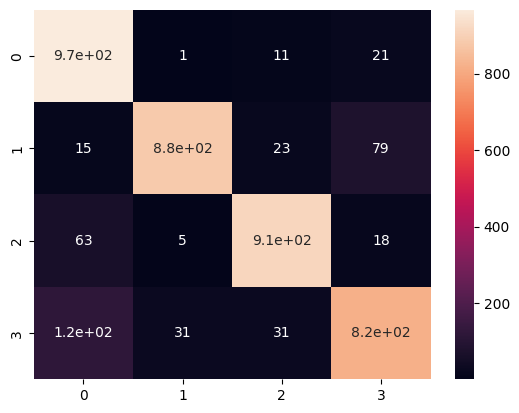

In [149]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

torch.cuda.empty_cache()

y_pred = ViT_clf.predict(X_train)
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True)

100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


              precision    recall  f1-score   support

           0      0.961     0.988     0.974       250
           1      0.949     0.964     0.956       250
           2      0.952     0.956     0.954       250
           3      0.979     0.932     0.955       250

    accuracy                          0.960      1000
   macro avg      0.960     0.960     0.960      1000
weighted avg      0.960     0.960     0.960      1000



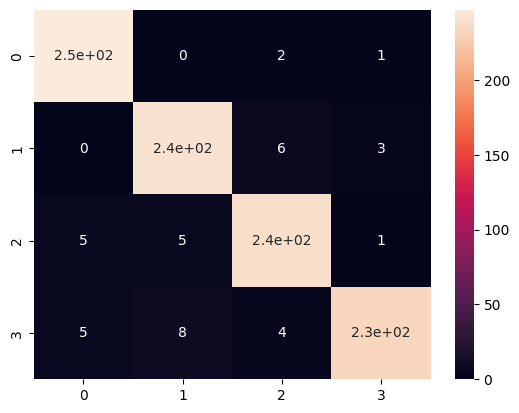

In [150]:
y_pred = ViT_clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test, y_pred, digits=3))

In [156]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def get_attention_map(img, model):
    x = torch.from_numpy(img).cuda()

    logits, att_mat = model(x, output_attention=True)
    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1)).cuda()
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size()).cuda()
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().cpu().numpy()
    mask = cv2.resize(mask / mask.max(), img.shape[:2])[..., np.newaxis]
    result = (mask * img).astype("uint8")

    return result, mask

def plot_attention_map(original_img, att_map):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map Last Layer')
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)

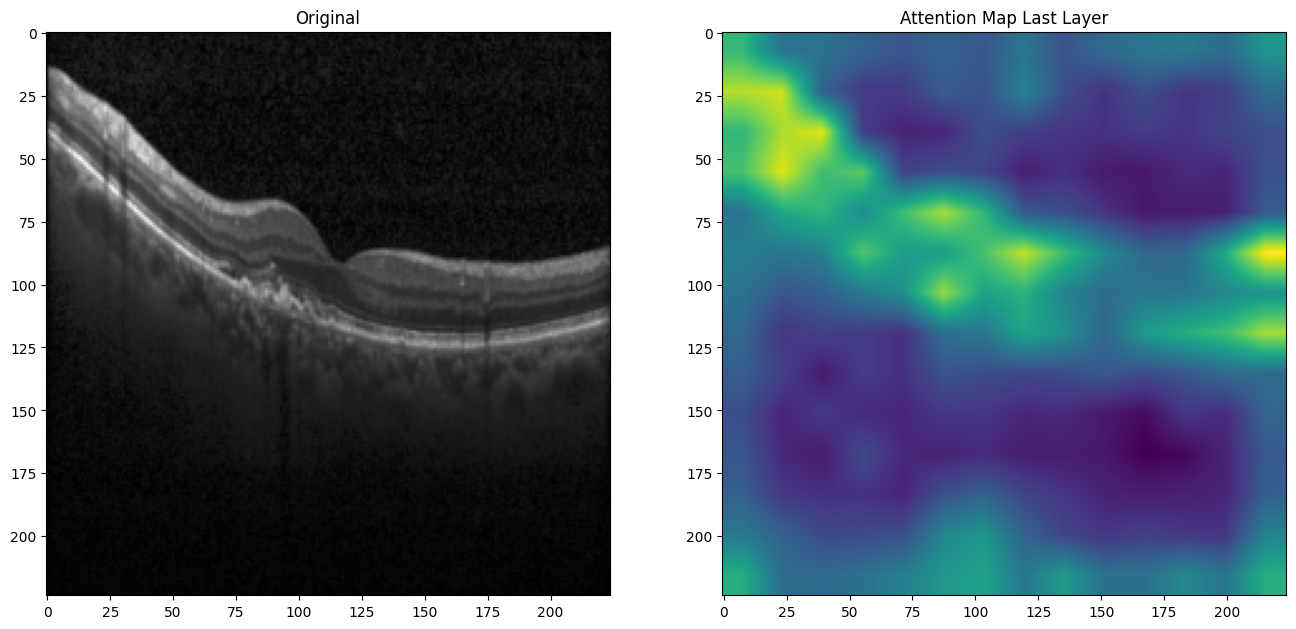

In [157]:
image1 = X_train[1011]
att_map1, att_map1_mask = get_attention_map(image1, ViT_clf.model)
plot_attention_map(image1, att_map1_mask)